<a href="https://colab.research.google.com/github/Asuna-sama-1/Horror_movies/blob/main/Horror_movie_review_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libarise and Functions

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from collections import Counter

from itertools import chain
from wordcloud import WordCloud
import pandas_profiling

from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### functions

In [148]:
def top_n_common_words(df,feature,n):
  #reviews = [i.split(' ') for i in df[feature]] # split sentence into words 
  reviews = list(chain(*df[feature])) # chain all words together 
  print('Total unique words: ', len(np.unique(np.array(reviews))))
  common_words_df = pd.DataFrame(Counter(reviews).most_common(n),columns=['words', 'count'])
  return common_words_df

In [149]:
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

def print_info(df,feature):
   print('Description:\n{}'.format(df[feature].describe()))
   print('*'*50)
   print('Object type:\n{}'.format(df[feature].dtype))
   print('*'*50)
   value_cnt = value_cnt_norm_cal(df,feature)
   print('Value count:\n{}'.format(value_cnt))

def create_bar_plot(df,feature):
  fig, ax = plt.subplots(figsize=(5,8))
  sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
  plt.xlabel('{}'.format(feature))
  plt.ylabel('Count')
  plt.title('{} count'.format(feature))
  total = float(len(df[feature])) 
  for i,n in enumerate(df[feature].value_counts(ascending = False)):
    percentage = '{:.1f}%'.format(n/total*100)
    i = i - 0.2
    n = n + 100
    ax.annotate(percentage,xy=(i,n))
  return plt.show()

def top_n_bar_plot(df,feature,n):
  fig, ax = plt.subplots(figsize=(20,4))
  sns.barplot(x=value_cnt_norm_cal(df,feature).index[:n],y=value_cnt_norm_cal(df,feature).values[:n,0])
  ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
  plt.xlabel('{}'.format(feature))
  plt.ylabel('Count')
  plt.title('Top {} {} count'.format(n,feature))
  return plt.show()

def create_hist_plot(df, feature, num_bin):
  if feature in ['review_date']:
    df[feature] = pd.to_datetime(df[feature])
    fig, ax = plt.subplots(figsize=(15,8))
    sns.histplot(df[feature],bins=num_bin,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()
  else:
    fig, ax = plt.subplots(figsize=(15,8))
    sns.histplot(df[feature],bins=num_bin,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

## 1. Load Data 

In [121]:
movies_data= pd.read_csv('rotten_tomatoes_movies.csv')
review_data = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

In [122]:
review_data.shape

(1130017, 8)

In [123]:
# get rid of null values in genres 
movies_data = movies_data[~movies_data['genres'].isnull()]

# get horror related movies
movies_data=movies_data[movies_data['genres'].str.contains('Horror')]

In [124]:
merged_data = pd.merge(review_data,movies_data,on='rotten_tomatoes_link').iloc[:,:8]

## 2. Data Cleaning

In [125]:
data = merged_data.copy()
len(data)

107823

### 2.1 Duplicates

In [10]:
def check_duplicates(df):
  if df.duplicated().sum() == 0:
    print('No duplicates detected')
  else:
    print('Orginal contains',df.duplicated().sum(),'duplicates')
    df.drop_duplicates(keep=False,inplace=True)
    print('New dataframe contains',data.duplicated().sum(),'duplicates')

In [126]:
check_duplicates(data)
len(data)

Orginal contains 12193 duplicates
New dataframe contains 0 duplicates


83437

### 2.2 Null values

In [12]:
def missing_data_pec(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  return missing_data

In [127]:
missing_data_pec(data)

Total   Percent
review_score          22161  0.265602
review_content         5073  0.060800
critic_name            1317  0.015784
rotten_tomatoes_link      0  0.000000
top_critic                0  0.000000
publisher_name            0  0.000000
review_type               0  0.000000
review_date               0  0.000000

In [14]:
# drop missing values in review_score column
cleaned_data = data[~data['review_content'].isnull()]
cleaned_data = cleaned_data[~cleaned_data['review_score'].isnull()]

In [15]:
# fill missing critic_name 
cleaned_data['critic_name'] = data['critic_name'].fillna('no name')

In [129]:
missing_data_pec(cleaned_data)
print('length of new cleaned data',len(cleaned_data))

length of new cleaned data 12448


### 2.3 Data Structure

In [130]:
cleaned_data.describe().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count unique                   top   freq      first  \
rotten_tomatoes_link  12448    450  m/a_quiet_place_2018    261        NaT   
critic_name           12448   1817             Ken Hanke    176        NaT   
top_critic            12448      2                 False  10211        NaT   
publisher_name        12448    903       eFilmCritic.com    304        NaT   
review_type           12448      2                 Fresh   6532        NaT   
review_score          12448    177                   3/5   1213        NaT   
review_date           12448   3665   2000-01-01 00:00:00    698 1800-01-01   
review_content        12448  12440  full review in Greek      4        NaT   
ratings               12448      5                     B   4127        NaT   

                           last  
rotten_tomatoes_link        NaT  
critic_name                 NaT  
top_critic                  NaT  
publisher_name              NaT  
review_type                 NaT  
review_score                NaT  
review_date          2020-10-21  
review_content              NaT  
ratings                     NaT

**some of the review_score is out of 5 some of them are out of 10, and some of them are in in alphabet. We need to fix the structural first.** 



In [131]:
my_list = []
for i in cleaned_data['review_score']:
        # rating types (alphabet) : only A B C D F
  if re.match("[a-zA-Z]",i):  
    i = list(i)[0]
    my_list.append(i)

           # rating with percentages 
  elif '/' in i:              
    if float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.2:
      i = 'F'
    elif (float(i.split('/')[0]) / float(i.split('/')[1]) > 0.2) and float(float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.4):
      i = 'D'
    elif (float(i.split('/')[0]) / float(i.split('/')[1]) > 0.4) and (float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.6):
      i = 'C'
    elif (float(i.split('/')[0]) / float(i.split('/')[1]) > 0.6) and (float(i.split('/')[0]) / float(i.split('/')[1]) <= 0.8):
       i = 'B'
    else:
       i = 'A'
    my_list.append(i)

          # rating without percentages  
  else:
    if int(i) <= 2:
      i = 'F'
    elif int(i) > 2 and int(i) <= 4:
      i = 'D'
    elif int(i) > 4 and int(i) <= 6:
      i = 'C'
    elif int(i) > 6 and int(i) <= 8:
      i = 'B'
    else:
      i = 'A'
    my_list.append(i)

Counter(my_list)

Counter({'A': 1340, 'B': 4127, 'C': 3239, 'D': 2669, 'F': 1073})

In [132]:
cleaned_data['ratings'] = my_list

## 3. Data Exploraton 

In [133]:
cleaned_data.describe().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count unique                   top   freq      first  \
rotten_tomatoes_link  12448    450  m/a_quiet_place_2018    261        NaT   
critic_name           12448   1817             Ken Hanke    176        NaT   
top_critic            12448      2                 False  10211        NaT   
publisher_name        12448    903       eFilmCritic.com    304        NaT   
review_type           12448      2                 Fresh   6532        NaT   
review_score          12448    177                   3/5   1213        NaT   
review_date           12448   3665   2000-01-01 00:00:00    698 1800-01-01   
review_content        12448  12440  full review in Greek      4        NaT   
ratings               12448      5                     B   4127        NaT   

                           last  
rotten_tomatoes_link        NaT  
critic_name                 NaT  
top_critic                  NaT  
publisher_name              NaT  
review_type                 NaT  
review_score                NaT  
review_date          2020-10-21  
review_content              NaT  
ratings                     NaT

#### 3.1 Distribution of Ratings




Description:
count     12448
unique        5
top           B
freq       4127
Name: ratings, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
B   4127      33.153920
C   3239      26.020244
D   2669      21.441195
A   1340      10.764781
F   1073       8.619859


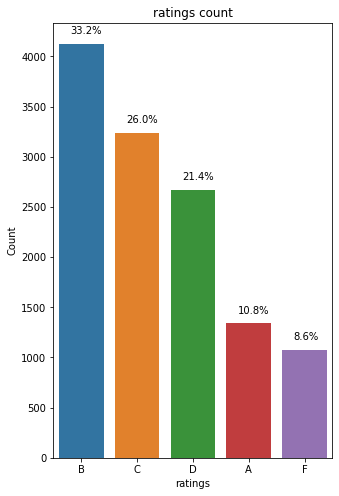

In [134]:
print_info(cleaned_data,'ratings')
create_bar_plot(cleaned_data,'ratings')

The data is follow exponential distribution. As most reviews rates are tend to be on the middle towards lower side, there are about 17.2% of reviews are on the extreme level. To be specificly, B is the most common(33.6%) rate given,and the second most common rate is cC, which contributes 27.6% of the all the ratings.

####  3.2 Top reviewed Movies

In [135]:
print_info(cleaned_data,'rotten_tomatoes_link')

Description:
count                    12448
unique                     450
top       m/a_quiet_place_2018
freq                       261
Name: rotten_tomatoes_link, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                           Count  Frequency (%)
m/a_quiet_place_2018         261       2.096722
m/1189344-lovely_bones       183       1.470116
m/1194949-wolfman            173       1.389781
m/28_days_later              169       1.357648
m/blair_witch                164       1.317481
...                          ...            ...
m/bad_blood_the_movie          1       0.008033
m/bride_of_the_gorilla         1       0.008033
m/1107688-bad_seed             1       0.008033
m/1021681-toolbox_murders      1       0.008033
m/1021262-thirst               1       0.008033

[450 rows x 2 columns]


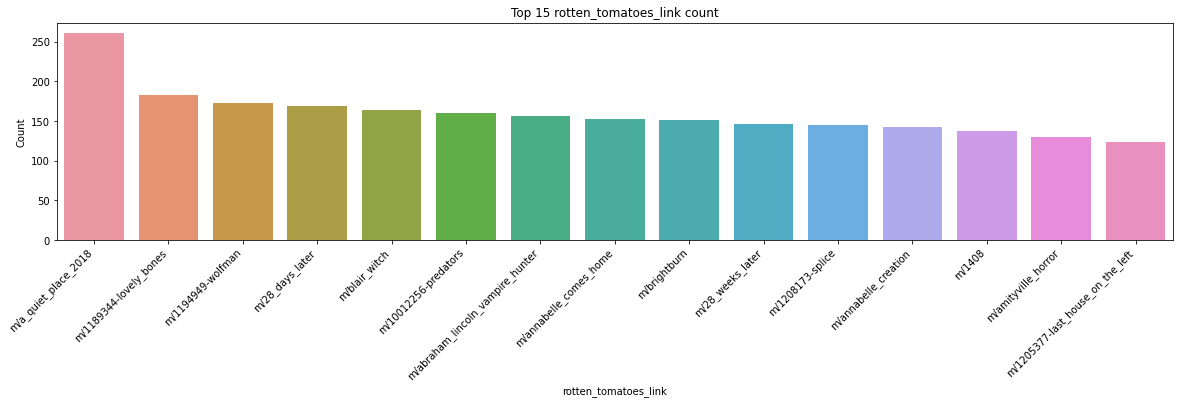

In [136]:
top_n_bar_plot(cleaned_data,'rotten_tomatoes_link',15)

The most reviwed movie is 'US' in 2019 followed by 'the_invisible_man' 2020.

####  3.3 Top publishers

Description:
count               12448
unique                903
top       eFilmCritic.com
freq                  304
Name: publisher_name, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                                 Count  Frequency (%)
eFilmCritic.com                    304       2.442159
Mountain Xpress (Asheville, NC)    177       1.421915
Reel Film Reviews                  174       1.397815
Filmcritic.com                     171       1.373715
Dennis Schwartz Movie Reviews      163       1.309447
...                                ...            ...
Cinemayward                          1       0.008033
FrewFilm                             1       0.008033
MovieMinis                           1       0.008033
Always Good Movies                   1       0.008033
Lucy Goes to Hollywood               1       0.008033

[903 rows x 2 columns]


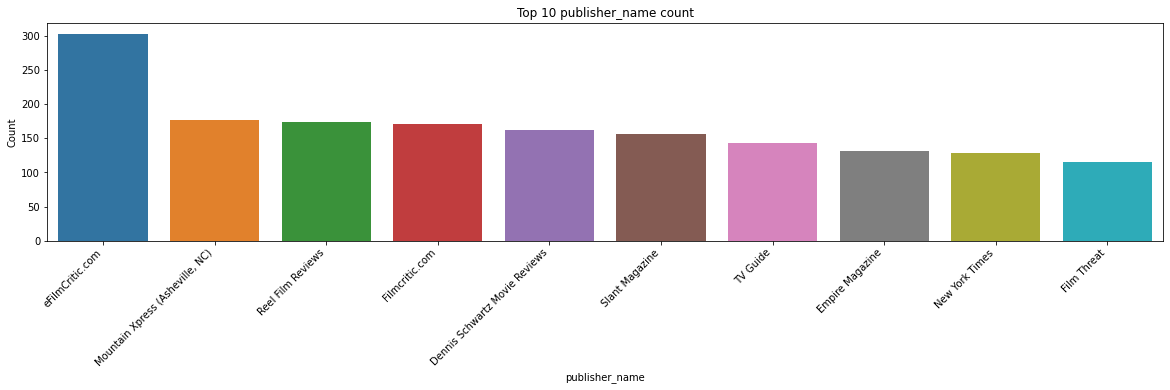

In [137]:
print_info(cleaned_data,'publisher_name')
top_n_bar_plot(cleaned_data,'publisher_name',10)

#### 3.4 Distribution of review date 

In [138]:
value_cnt_norm_cal(cleaned_data,'review_date').sort_index()

Count  Frequency (%)
1800-01-01      2       0.016067
1963-03-28      1       0.008033
1981-08-21      1       0.008033
1982-07-01      1       0.008033
1990-07-18      1       0.008033
...           ...            ...
2020-10-13      2       0.016067
2020-10-14      2       0.016067
2020-10-19      3       0.024100
2020-10-20      3       0.024100
2020-10-21      3       0.024100

[3665 rows x 2 columns]

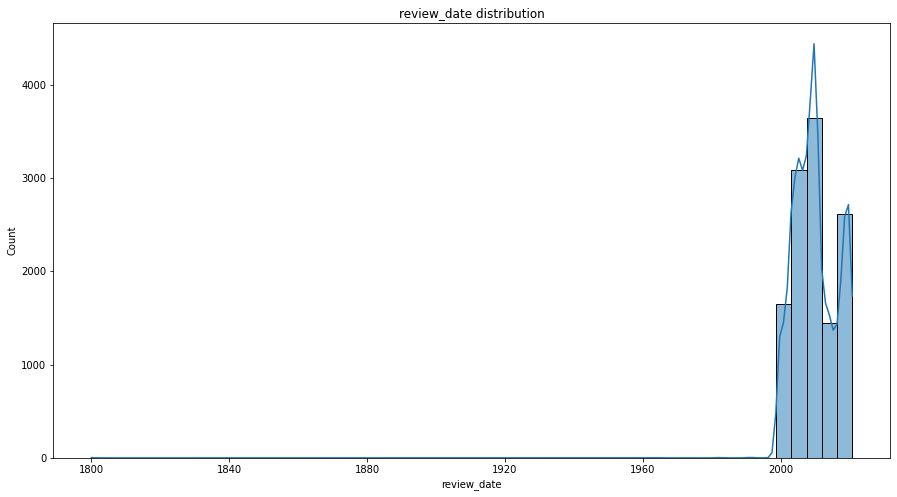

In [139]:
create_hist_plot(cleaned_data,'review_date',50)

It's kinda impossible that the review date starts from 1800. This outliers are caused most likly by data collection mistake. 

Let's only focuse on dates that after 2000. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Description:
count                   12438
unique                   3656
top       2000-01-01 00:00:00
freq                      698
first     2000-01-01 00:00:00
last      2020-10-21 00:00:00
Name: review_date, dtype: object
**************************************************
Object type:
datetime64[ns]
**************************************************
Value count:
            Count  Frequency (%)
2000-01-01    698       5.611835
2009-12-11     61       0.490433
2012-06-21     56       0.450233
2007-05-11     56       0.450233
2007-06-22     51       0.410034
...           ...            ...
2003-07-21      1       0.008040
2003-07-19      1       0.008040
2003-07-15      1       0.008040
2003-07-04      1       0.008040
2004-04-19      1       0.008040

[3656 rows x 2 columns]


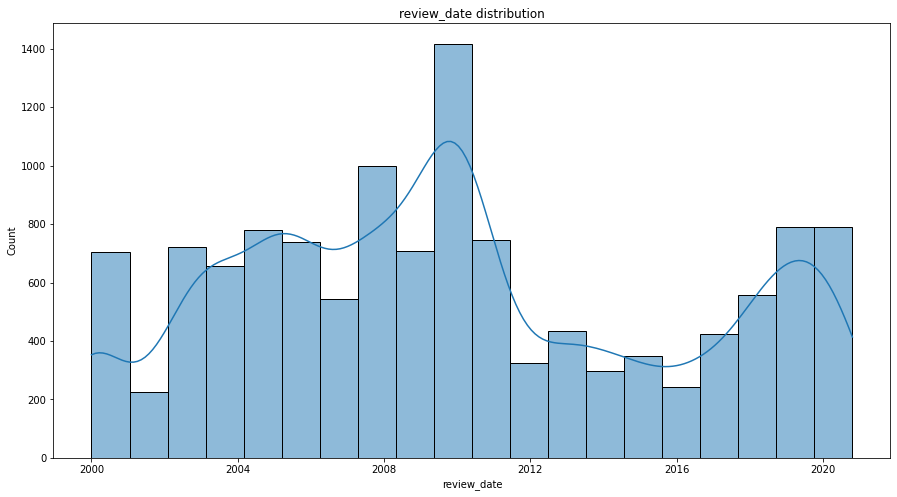

In [140]:
#cleaned_data[cleaned_data['review_date']>='2000-01-01'].review_date

print_info(cleaned_data[cleaned_data['review_date']>='2000-01-01'],'review_date')
create_hist_plot( cleaned_data[cleaned_data['review_date']>='2000-01-01'],'review_date',20)

#### 3.5 Review Content Length Distribution


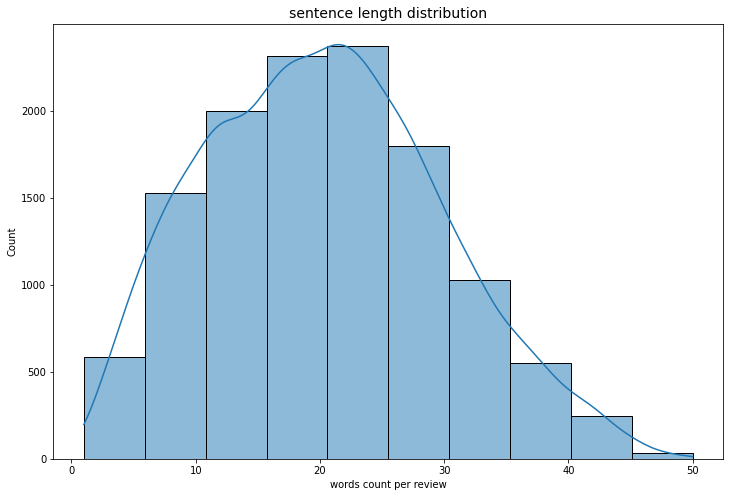

Longest sentence:  50  words.
Shortest sentence:  1  words.


In [141]:
length_dist = [len(x.split(" ")) for x in cleaned_data['review_content']]

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(length_dist,bins=10,kde=True)
plt.xlabel('words count per review')
plt.ylabel('Count')
plt.title('sentence length distribution', fontsize=14)
plt.show()

print('Longest sentence: ', max(length_dist)," words.")
print('Shortest sentence: ', min(length_dist)," words.")

## 4. Review Data Exploration

In [142]:
reviews_data = cleaned_data.copy()

1. lowercase
2. sentence
3. words
4. white space
5. remove punctuation
6. removes numbers
7. stopwords

In [143]:
len(reviews_data['review_content'])

12448

### 4.1  Review Data Processing

In [144]:
# convert text to lower-case, remove [],  and punctuation

def text_clean_1(text):
  text = text.lower()
  text = re.sub('\[.*?\]','',text)
  text = re.sub('\w*\d\w*','',text)
  text = re.sub('\n','',text)
  text = re.sub('[''""...]','',text)
  text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
  return text

cleaned_1 = lambda x : text_clean_1(x)

In [145]:
# apply first layer of cleaning 
reviews_data['cleaned1']=pd.DataFrame(reviews_data['review_content'].apply(cleaned_1))
reviews_data['cleaned1']

0        while dark water isnt a complete wash no pun i...
2        the picture is melancholy remembrance and its ...
3        a horror movie that sits there and drags and s...
4        just beneath its surface horror this film conc...
6        with extremely heavy echoes of his own  film r...
                               ...                        
19210    not a great movie by any stretch of the imagin...
19211    elvis is in a geriatric care centre with jfk w...
19212    don coscarelli still doesnt know how to make c...
19213    this absurdly clever caper is elevated by bruc...
19218    despite having a fascinating setup and an exce...
Name: cleaned1, Length: 12448, dtype: object

#### **STOPWORDS**

In [150]:
# adding words to NLTL stopwords list 

stopwords = stopwords.words('english')
newStopWords = ['films','movie','yet','films','film','horror','one','u','time','way','thats']
stopwords.extend(newStopWords)

In [151]:
def nltk_stopwords(data):
    words = []
    for i in data:
      if i not in stopwords:
          words.append(i)
    return words

def remove_stopwords(df, feature):
  df['words_nltk'] = df[feature].apply(word_tokenize)
  df['words_nltk']= df['words_nltk'].apply(nltk_stopwords)
  print("Successfully created 'words_nltk' column")

In [152]:
remove_stopwords(reviews_data,'cleaned1')

Successfully created 'words_nltk' column


In [153]:
reviews_data['words_nltk']

0        [dark, water, isnt, complete, wash, pun, inten...
2        [picture, melancholy, remembrance, sources, fe...
3        [sits, drags, seems, full, based, premise, pud...
4        [beneath, surface, conceals, deep, reservoir, ...
6        [extremely, heavy, echoes, ringu, nakata, subt...
                               ...                        
19210    [great, stretch, imagination, theres, enough, ...
19211    [elvis, geriatric, care, centre, jfk, whos, bl...
19212    [coscarelli, still, doesnt, know, make, cookie...
19213    [absurdly, clever, caper, elevated, bruce, cam...
19218    [despite, fascinating, setup, excellent, turn,...
Name: words_nltk, Length: 12448, dtype: object

#### **STEMMING**

In [154]:
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')

reviews_data['stemmed'] = reviews_data['words_nltk'].apply(lambda x: [snow_stemmer.stem(y) for y in x])
print("Successfully created 'stemmed' column")

Successfully created 'stemmed' column


In [155]:
print(reviews_data['words_nltk'][2])
print(reviews_data['stemmed'][2])

['picture', 'melancholy', 'remembrance', 'sources', 'fear', 'intimate', 'brilliant']
['pictur', 'melancholi', 'remembr', 'sourc', 'fear', 'intim', 'brilliant']


#### **Lemmatisation**

In [156]:
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

reviews_data['Lemmatized'] = reviews_data['words_nltk'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
print("Successfully created 'Lemmatized' column")

Successfully created 'Lemmatized' column


In [157]:
print(reviews_data['words_nltk'][2])
print(reviews_data['stemmed'][2])
print(reviews_data['Lemmatized'][2])

['picture', 'melancholy', 'remembrance', 'sources', 'fear', 'intimate', 'brilliant']
['pictur', 'melancholi', 'remembr', 'sourc', 'fear', 'intim', 'brilliant']
['picture', 'melancholy', 'remembrance', 'source', 'fear', 'intimate', 'brilliant']


### 4.2 **NLTK**

#### 4.2.1 NLTK - all words

##### **ALL**

In [158]:
def common_words_ratings(df,rating_col,words_col, n):
  common_words_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    words_list = []
    for w in df[df[rating_col] == i][words_col]:
      words_list.extend(w)
    common_words_ratings[i] = Counter(words_list).most_common(n)
  return common_words_ratings

In [159]:
common_words_ratings(reviews_data, 'ratings', 'Lemmatized',20)

A                   B                 C                D  \
0         (best, 109)         (like, 238)       (like, 228)      (like, 198)   
1       (classic, 86)         (good, 236)       (make, 172)      (even, 141)   
2         (genre, 75)         (make, 218)       (good, 165)      (much, 136)   
3         (movie, 71)        (story, 197)      (story, 164)      (make, 135)   
4          (like, 68)        (genre, 177)       (much, 160)     (story, 115)   
5          (make, 67)          (fun, 175)  (character, 126)       (good, 96)   
6         (great, 64)     (thriller, 168)     (enough, 124)        (bad, 94)   
7          (year, 61)         (much, 160)     (little, 119)      (movie, 92)   
8          (ever, 56)        (great, 159)        (get, 115)  (character, 92)   
9         (story, 51)         (even, 156)     (doesnt, 114)        (get, 91)   
10        (place, 51)  (performance, 148)        (fun, 113)      (there, 88)   
11     (thriller, 47)         (best, 145)       (even, 112)     (enough, 85)   
12        (scary, 45)         (work, 144)      (genre, 108)      (thing, 82)   
13  (performance, 44)     (director, 143)       (work, 106)     (little, 81)   
14         (even, 44)     (original, 134)      (scare, 106)     (doesnt, 77)   
15         (made, 43)        (movie, 131)      (scary, 104)    (nothing, 76)   
16         (good, 43)         (take, 130)      (thing, 101)     (better, 75)   
17         (work, 43)          (get, 130)    (original, 98)      (scary, 74)   
18        (still, 42)         (well, 129)       (movie, 97)       (idea, 74)   
19     (original, 41)        (still, 125)    (thriller, 95)      (could, 71)   

                 F  
0        (bad, 73)  
1       (even, 69)  
2       (like, 57)  
3       (make, 54)  
4      (worst, 54)  
5      (movie, 44)  
6      (would, 40)  
7       (made, 39)  
8      (could, 37)  
9       (year, 36)  
10      (good, 35)  
11      (much, 32)  
12      (ever, 31)  
13     (thing, 30)  
14  (director, 29)  
15     (scary, 29)  
16   (nothing, 28)  
17     (awful, 27)  
18    (effect, 27)  
19     (there, 27)

Total unique words:  19543


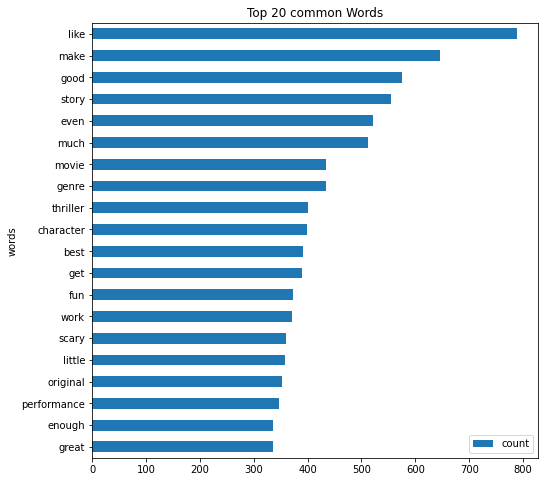

In [160]:
top_20 = top_n_common_words(reviews_data,'Lemmatized',20)

fig, ax = plt.subplots(figsize=(8, 8))

top_20.sort_values(by='count').plot.barh(x='words',y='count',ax=ax)

ax.set_title("Top {} common Words".format(20))
plt.show()

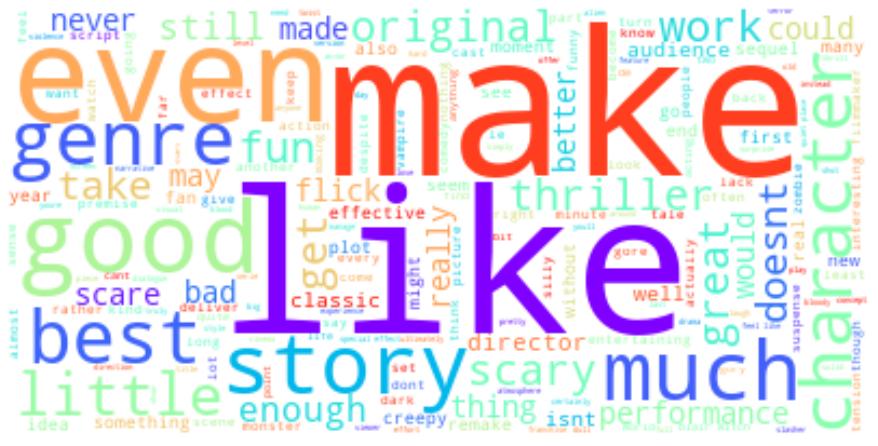

In [161]:
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*reviews_data['Lemmatized']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

##### Reviews sentiment

In [162]:
# assign reviews with rate = C D F as negative sentiment
# assign reviews with rate = A B positive sentiment

reviews_data['sentiment'] = reviews_data['ratings'].apply(lambda rating : 'positive' if rating in ['A', 'B'] else 'negative')

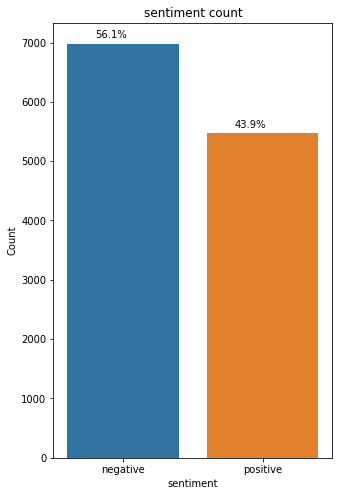

In [163]:
create_bar_plot(reviews_data,'sentiment')

In [164]:
# create two dataframe: pos_df and neg_df

pos_df = reviews_data[reviews_data['sentiment'] == 'positive']
neg_df = reviews_data[reviews_data['sentiment'] == 'negative']

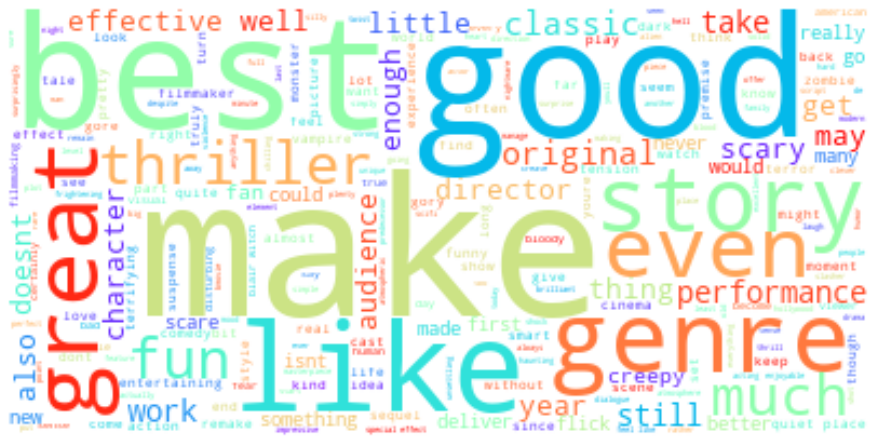

In [165]:
# create wordcloud for positive reviews
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*pos_df['Lemmatized']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

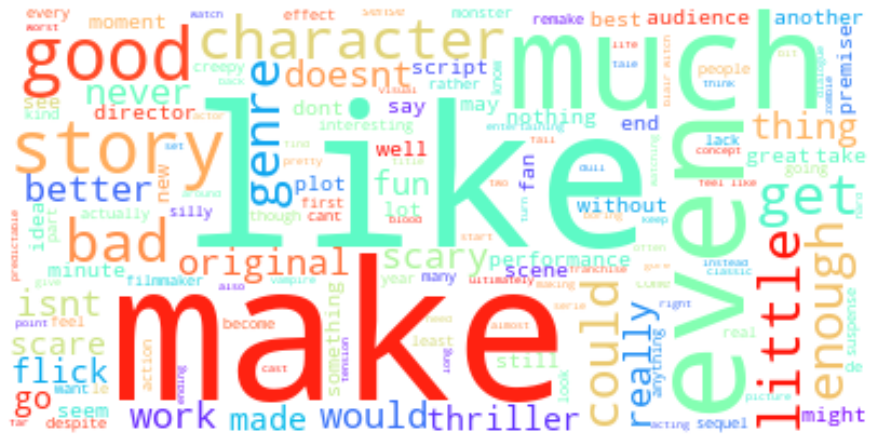

In [166]:
# create wordcloud for negative reviews
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*neg_df['Lemmatized']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

#### 4.2.2 NLTK(PartOfSpeech) - adjectives 

In [167]:
def get_adjective(x):
    adj = ['JJ', 'JJR', 'JJS']
    word = []
    for i in x:
        if i[1] in adj:
            word.append(i[0])
    return word

def nltk_postag_adj(df, feature):
  # add pos tags 
  df['pos_tag'] = df[feature].apply(nltk.pos_tag)
  # get adjectives
  df['adj_words'] = df['pos_tag'].apply(get_adjective)
  print("Successfully created 'adj_words' column")

def common_adj_ratings(df,rating_col,adj_col, n):
  common_adj_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    adj_list = []
    for w in df[df[rating_col] == i][adj_col]:
      adj_list.extend(w)
    common_adj_ratings[i] = Counter(adj_list).most_common(n)
  return common_adj_ratings

In [168]:
nltk_postag_adj(reviews_data,'Lemmatized')
common_adj_ratings(reviews_data, 'ratings', 'adj_words',20)

Successfully created 'adj_words' column


A                 B                  C                  D  \
0        (best, 87)       (good, 230)        (good, 161)        (much, 106)   
1     (classic, 76)      (great, 159)        (much, 121)          (bad, 94)   
2       (great, 64)   (original, 131)      (little, 114)         (good, 92)   
3        (good, 42)       (much, 128)     (original, 96)       (little, 77)   
4    (original, 41)     (little, 120)        (scary, 94)        (scary, 68)   
5       (scary, 41)       (best, 117)          (bad, 90)     (original, 61)   
6       (quiet, 40)  (effective, 107)        (great, 74)          (new, 51)   
7    (american, 32)        (new, 102)          (new, 68)         (many, 43)   
8       (black, 27)    (classic, 101)         (best, 61)       (enough, 41)   
9         (new, 25)       (scary, 95)       (enough, 60)         (real, 39)   
10  (effective, 22)           (u, 79)         (many, 52)        (least, 37)   
11     (modern, 22)        (many, 69)      (classic, 49)         (best, 34)   
12       (many, 22)        (real, 68)    (effective, 45)         (last, 34)   
13       (much, 20)         (bad, 63)         (real, 43)      (special, 33)   
14       (true, 20)       (black, 61)        (black, 43)            (u, 33)   
15    (perfect, 19)       (quiet, 56)        (first, 42)         (full, 32)   
16          (u, 19)     (special, 51)  (predictable, 41)          (big, 31)   
17     (little, 17)       (funny, 51)            (u, 39)        (black, 31)   
18       (high, 17)       (human, 44)         (last, 39)          (old, 30)   
19    (special, 17)         (old, 43)        (final, 38)  (interesting, 29)   

                 F  
0        (bad, 73)  
1      (worst, 46)  
2       (good, 35)  
3      (scary, 29)  
4      (awful, 26)  
5       (much, 26)  
6     (stupid, 18)  
7   (original, 17)  
8       (dark, 17)  
9        (uwe, 16)  
10    (little, 16)  
11      (real, 15)  
12       (big, 14)  
13      (best, 14)  
14      (many, 14)  
15         (u, 13)  
16   (special, 12)  
17     (least, 12)  
18       (uma, 11)  
19     (worse, 11)

Total unique words:  6209


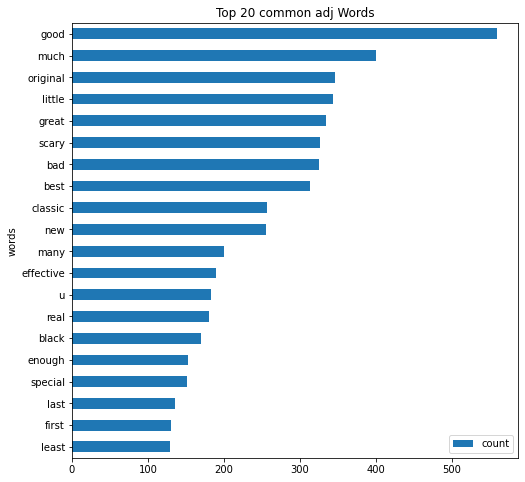

In [169]:
top_20_adj = top_n_common_words(reviews_data,'adj_words',20)
fig, ax = plt.subplots(figsize=(8, 8))
top_20_adj.sort_values(by='count').plot.barh(x='words',y='count',ax=ax)
ax.set_title("Top {} common adj Words".format(20))
plt.show()

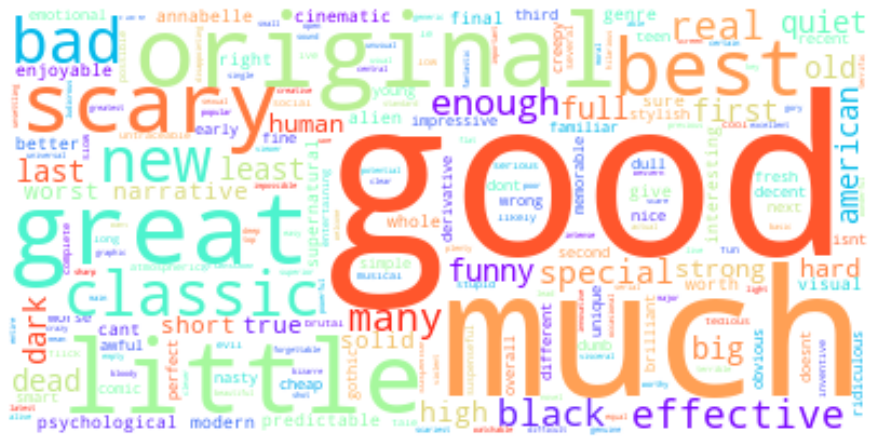

In [170]:
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*reviews_data['adj_words']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [174]:
# create two dataframe: pos_df and neg_df

pos_df = reviews_data[reviews_data['sentiment'] == 'positive']
neg_df = reviews_data[reviews_data['sentiment'] == 'negative']

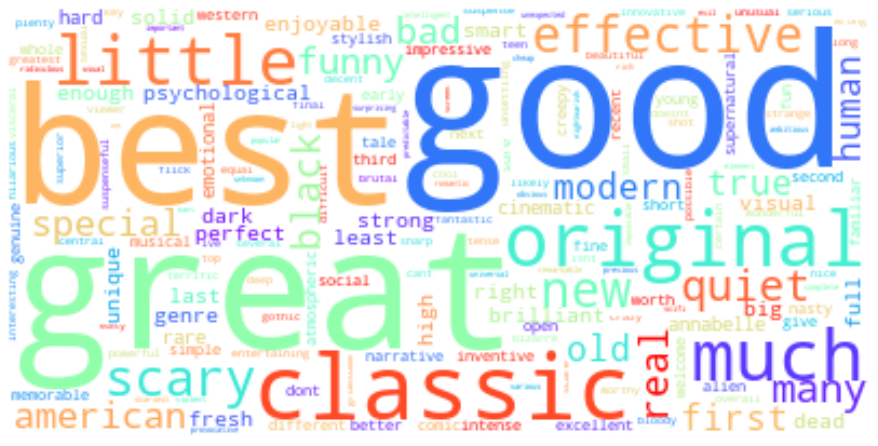

In [175]:
# create wordcloud for positive reviews
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*pos_df['adj_words']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

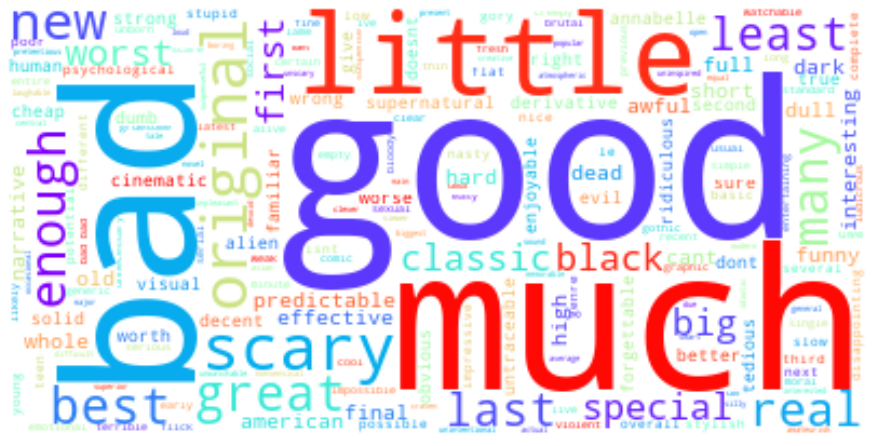

In [176]:
# create wordcloud for negative reviews
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*neg_df['adj_words']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

#### 4.2.3 NLTK(PartOfSpeech) - nouns 

In [177]:
def get_nouns(x):
    noun = ['NN', 'NNS', 'NNP', 'NNPS']
    word = []
    for i in x:
      if i[1] in noun:
        word.append(i[0])
    return word

def nltk_postag_noun(df, feature):
  # get noun
  df['noun_words'] = df['pos_tag'].apply(get_nouns)
  print("Successfully created 'noun_words' column")

def common_noun_ratings(df,rating_col,noun_col, n):
  common_noun_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    noun_list = []
    for w in df[df[rating_col] == i][noun_col]:
      noun_list.extend(w)
    common_noun_ratings[i] = Counter(noun_list).most_common(n)
  return common_noun_ratings

In [178]:
nltk_postag_noun(reviews_data,'Lemmatized')
common_noun_ratings(reviews_data, 'ratings', 'noun_words',20)

Successfully created 'noun_words' column


A                   B                  C  \
0         (movie, 71)        (story, 197)       (story, 164)   
1         (genre, 65)     (thriller, 158)   (character, 114)   
2          (year, 61)  (performance, 148)       (thing, 101)   
3         (story, 51)     (director, 143)        (movie, 97)   
4         (place, 51)        (genre, 142)          (fun, 96)   
5      (thriller, 47)          (fun, 137)       (moment, 93)   
6   (performance, 44)         (work, 132)  (performance, 92)   
7          (work, 41)        (movie, 131)         (work, 91)   
8        (cinema, 38)    (character, 111)     (thriller, 90)   
9      (audience, 35)       (effect, 101)        (scare, 89)   
10    (character, 34)         (thing, 96)        (genre, 83)   
11    (something, 33)           (fan, 93)       (doesnt, 80)   
12     (director, 27)         (flick, 90)     (director, 77)   
13      (vampire, 27)          (year, 88)       (effect, 74)   
14        (night, 27)     (something, 87)          (lot, 71)   
15      (monster, 26)       (vampire, 82)      (vampire, 70)   
16       (effect, 26)        (moment, 80)          (fan, 70)   
17       (comedy, 25)      (audience, 80)         (plot, 66)   
18          (day, 24)        (comedy, 78)         (isnt, 63)   
19      (picture, 23)         (place, 75)        (scene, 63)   

                    D                F  
0        (story, 115)      (movie, 44)  
1         (movie, 92)       (year, 36)  
2     (character, 86)      (thing, 30)  
3         (thing, 82)   (director, 29)  
4       (nothing, 76)    (nothing, 28)  
5          (idea, 74)     (effect, 27)  
6      (thriller, 70)      (story, 27)  
7          (plot, 64)   (audience, 27)  
8        (effect, 61)       (boll, 25)  
9        (doesnt, 58)       (plot, 24)  
10     (audience, 57)  (character, 24)  
11        (scare, 55)       (game, 22)  
12     (director, 54)       (work, 22)  
13        (flick, 51)  (something, 20)  
14  (performance, 51)   (thriller, 19)  
15        (sense, 50)     (people, 18)  
16          (end, 50)     (sequel, 18)  
17      (premise, 49)       (idea, 17)  
18        (scene, 48)        (que, 16)  
19       (minute, 48)      (youre, 16)

Total unique words:  11158


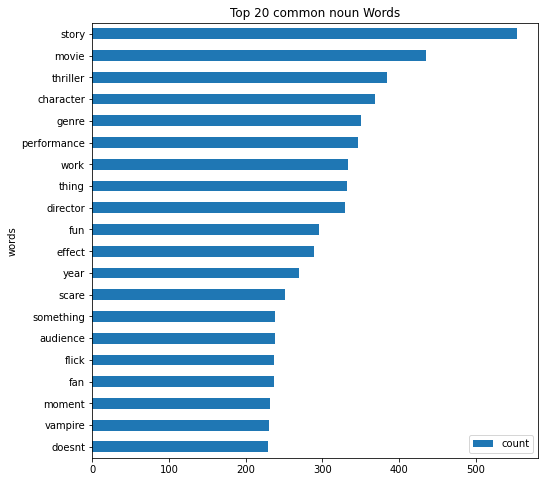

In [179]:
top_20_noun = top_n_common_words(reviews_data,'noun_words',20)
fig, ax = plt.subplots(figsize=(8, 8))
top_20_noun.sort_values(by='count').plot.barh(x='words',y='count',ax=ax)
ax.set_title("Top {} common noun Words".format(20))
plt.show()

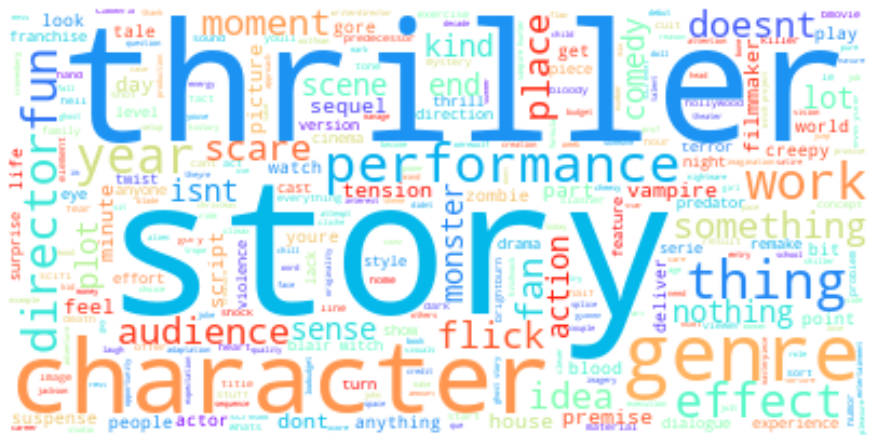

In [180]:
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*reviews_data['noun_words']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [181]:
# create two dataframe: pos_df and neg_df

pos_df = reviews_data[reviews_data['sentiment'] == 'positive']
neg_df = reviews_data[reviews_data['sentiment'] == 'negative']

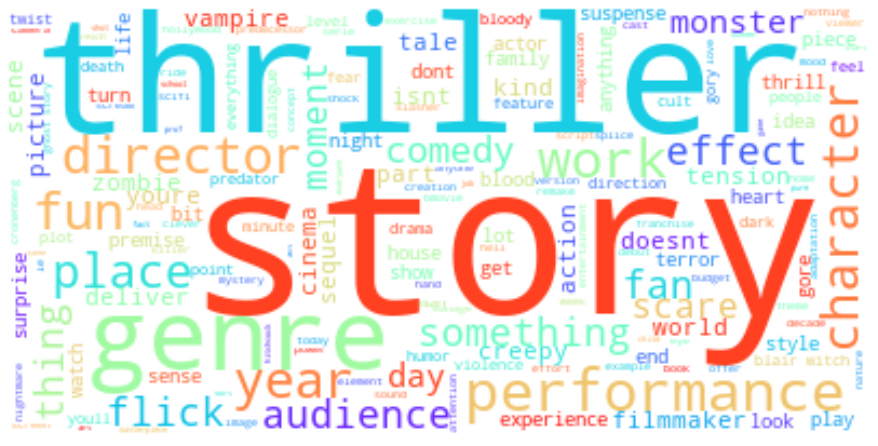

In [182]:
# create wordcloud for positive reviews
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*pos_df['noun_words']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

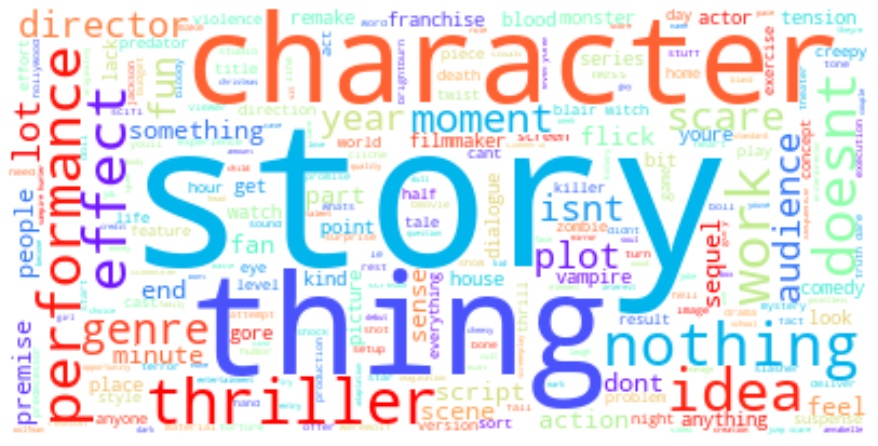

In [183]:
# create wordcloud for negative reviews
wordcloud = WordCloud(stopwords=stopwords,background_color='white', 
                      max_words=1000, 
                      contour_width=3,colormap='rainbow').generate((' ').join(list(chain(*neg_df['noun_words']))))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

#### 4.2.4 NLTK  (bi-grams)

In [184]:
def common_bigram_ratings(df,rating_col,word_col, n):
  common_bigrams_ratings = pd.DataFrame()
  for i in sorted(df[rating_col].unique()):
    word_list = []
    for w in df[df[rating_col] == i][word_col]:
      word_list.extend(w)
    bigram_list = list(nltk.bigrams(word_list))
    common_bigrams_ratings[i] = Counter(bigram_list).most_common(n)
  return common_bigrams_ratings

In [185]:
common_bigram_ratings(reviews_data, 'ratings', 'Lemmatized',20)

A                                B  \
0      ((quiet, place), 38)             ((quiet, place), 45)   
1        ((ever, made), 24)          ((special, effect), 36)   
2      ((blair, witch), 18)               ((feel, like), 36)   
3   ((special, effect), 15)             ((blair, witch), 36)   
4      ((ghost, story), 11)      ((annabelle, creation), 25)   
5         ((ive, seen), 11)             ((ghost, story), 24)   
6        ((ever, seen), 10)               ((day, later), 23)   
7        ((day, later), 10)            ((cult, classic), 19)   
8         ((king, kong), 9)          ((annabelle, come), 19)   
9     ((witch, project), 9)               ((come, home), 19)   
10      ((living, dead), 8)              ((week, later), 18)   
11        ((de, palmas), 8)           ((witch, project), 16)   
12      ((high, school), 8)                ((de, palma), 16)   
13     ((black, comedy), 8)         ((anna, apocalypse), 16)   
14   ((john, carpenter), 7)                 ((lot, fun), 14)   
15       ((best, movie), 7)            ((stephen, king), 14)   
16     ((night, living), 7)           ((blood, quantum), 14)   
17         ((de, palma), 7)  ((psychological, thriller), 13)   
18         ((ive, ever), 6)               ((von, trier), 13)   
19      ((easily, best), 6)        ((creature, feature), 11)   

                                 C                         D  \
0               ((feel, like), 36)        ((feel, like), 33)   
1             ((blair, witch), 32)      ((blair, witch), 29)   
2          ((special, effect), 27)   ((special, effect), 26)   
3          ((annabelle, come), 19)       ((truth, dare), 23)   
4               ((come, home), 19)        ((look, like), 18)   
5      ((annabelle, creation), 18)       ((alone, dark), 15)   
6          ((vampire, hunter), 17)        ((play, like), 12)   
7              ((jump, scare), 16)       ((wes, craven), 12)   
8                ((del, toro), 15)         ((two, hour), 11)   
9         ((abraham, lincoln), 15)       ((there, much), 11)   
10        ((lincoln, vampire), 14)    ((witch, project), 11)   
11          ((haunted, house), 13)  ((blood, chocolate), 11)   
12           ((worth, seeing), 12)      ((ghost, story), 10)   
13              ((play, like), 12)     ((torture, porn), 10)   
14            ((never, quite), 11)    ((slasher, flick), 10)   
15          ((serial, killer), 10)       ((jump, scare), 10)   
16           ((skeleton, key), 10)  ((abraham, lincoln), 10)   
17  ((character, development), 10)   ((vampire, hunter), 10)   
18            ((lovely, bone), 10)        ((make, sense), 9)   
19        ((black, christmas), 10)   ((action, sequence), 9)   

                                 F  
0                ((uwe, boll), 16)  
1              ((alone, dark), 16)  
2              ((video, game), 11)  
3               ((ever, made), 11)  
4             ((blair, witch), 11)  
5               ((look, like), 10)  
6           ((special, effect), 9)  
7             ((torture, porn), 8)  
8               ((worst, year), 8)  
9                  ((ed, wood), 8)  
10       ((battlefield, earth), 8)  
11          ((possibly, worst), 6)  
12           ((richard, kelly), 6)  
13  ((psychological, thriller), 6)  
14              ((worst, ever), 6)  
15             ((worst, movie), 5)  
16              ((stay, alive), 5)  
17             ((ghost, story), 5)  
18           ((there, nothing), 5)  
19                 ((bad, bad), 5)

In [261]:
reviews_data.to_csv('final_review_df.csv')

## Model Training and Evaluations

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [188]:
def evaluation(preds, test_y):
  sns.heatmap(confusion_matrix(preds,test_y),annot=True,fmt='d')
  print('Accuracy: ',accuracy_score (preds,test_y))
  print(classification_report(preds, test_y))

#### Base model

x_train : 11203
x_test : 1245
y_train : 11203
y_test : 1245
Accuracy:  0.3004016064257028
              precision    recall  f1-score   support

           A       0.11      0.13      0.12       110
           B       0.44      0.38      0.41       455
           C       0.32      0.33      0.32       333
           D       0.23      0.24      0.23       258
           F       0.15      0.18      0.16        89

    accuracy                           0.30      1245
   macro avg       0.25      0.25      0.25      1245
weighted avg       0.31      0.30      0.31      1245



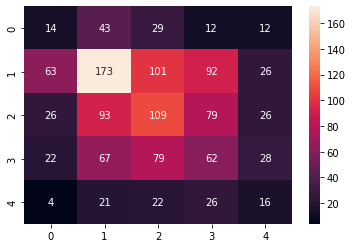

In [248]:
# base model with ratings 

X = reviews_data['review_content']
Y = reviews_data['ratings']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.1, random_state =42)

print('x_train :',len(x_train) )
print('x_test :',len(x_test) )
print('y_train :',len(y_train) )
print('y_test :',len(y_test) )


tifd_vec = TfidfVectorizer()
dt_model = DecisionTreeClassifier()

# build modeling pipeline 
model = Pipeline([  ('Vectorize', tifd_vec),  ('Classifier',dt_model) ])
model.fit(x_train, y_train)

predictions = model.predict(x_test)
evaluation(predictions, y_test)


x_train : 11203
x_test : 1245
y_train : 11203
y_test : 1245
Accuracy:  0.685140562248996
              precision    recall  f1-score   support

    negative       0.95      0.66      0.78      1037
    positive       0.33      0.82      0.47       208

    accuracy                           0.69      1245
   macro avg       0.64      0.74      0.62      1245
weighted avg       0.84      0.69      0.72      1245



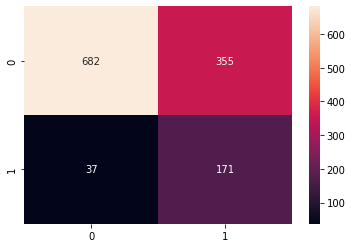

In [247]:
# base model with sentiment 

X = reviews_data['review_content']
Y = reviews_data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.1, random_state =42)

print('x_train :',len(x_train) )
print('x_test :',len(x_test) )
print('y_train :',len(y_train) )
print('y_test :',len(y_test) )

tifd_vec = TfidfVectorizer()
lr_model = LogisticRegression(penalty="l2", C=0.1)
# build modeling pipeline 
model = Pipeline([  ('Vectorize', tifd_vec),  ('Classifier',lr_model) ])
model.fit(x_train, y_train)

predictions = model.predict(x_test)
evaluation(predictions, y_test)

####  Lemmatized 

In [222]:
def text_clean_2(text):
   text = (" ").join(text)
   return text

to_str = lambda x : text_clean_2(x)    
reviews_data['Lemmatized_str'] = reviews_data['Lemmatized'].apply(to_str)

x_train : 11203
x_test : 1245
y_train : 11203
y_test : 1245
Accuracy:  0.3204819277108434
              precision    recall  f1-score   support

           A       0.17      0.24      0.20        92
           B       0.43      0.39      0.41       441
           C       0.34      0.30      0.32       381
           D       0.27      0.30      0.28       244
           F       0.16      0.20      0.17        87

    accuracy                           0.32      1245
   macro avg       0.27      0.28      0.28      1245
weighted avg       0.33      0.32      0.33      1245



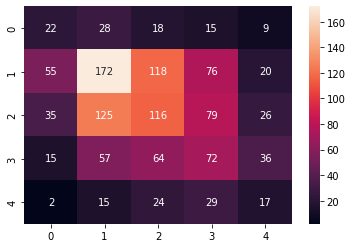

In [250]:
#dt with Lemmatized data and ratings

X = reviews_data['Lemmatized_str']
Y = reviews_data['ratings']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.1, random_state =42)

print('x_train :',len(x_train) )
print('x_test :',len(x_test) )
print('y_train :',len(y_train) )
print('y_test :',len(y_test) )

tifd_vec = TfidfVectorizer()
dt_model = DecisionTreeClassifier()

# build modeling pipeline 
model = Pipeline([  ('Vectorize', tifd_vec),  ('Classifier',dt_model) ])
model.fit(x_train, y_train)

predictions = model.predict(x_test)
evaluation(predictions, y_test)

x_train : 11203
x_test : 1245
y_train : 11203
y_test : 1245
Accuracy:  0.6184738955823293
              precision    recall  f1-score   support

    negative       0.65      0.68      0.66       688
    positive       0.58      0.55      0.56       557

    accuracy                           0.62      1245
   macro avg       0.61      0.61      0.61      1245
weighted avg       0.62      0.62      0.62      1245



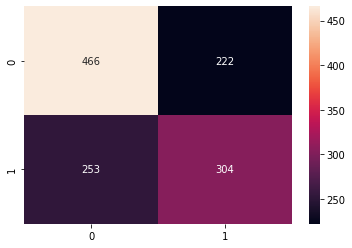

In [249]:
#lr with Lemmatized data and sentiment

X = reviews_data['Lemmatized_str']
Y = reviews_data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.1, random_state =42)

print('x_train :',len(x_train) )
print('x_test :',len(x_test) )
print('y_train :',len(y_train) )
print('y_test :',len(y_test) )

tifd_vec = TfidfVectorizer()
dt_model = DecisionTreeClassifier()

# build modeling pipeline 
model = Pipeline([  ('Vectorize', tifd_vec),  ('Classifier',dt_model) ])
model.fit(x_train, y_train)

predictions = model.predict(x_test)
evaluation(predictions, y_test)

In [252]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

x_train : 11203
x_test : 1245
y_train : 11203
y_test : 1245
Accuracy:  0.7309236947791165
              precision    recall  f1-score   support

    negative       0.90      0.71      0.79       906
    positive       0.50      0.78      0.61       339

    accuracy                           0.73      1245
   macro avg       0.70      0.75      0.70      1245
weighted avg       0.79      0.73      0.74      1245



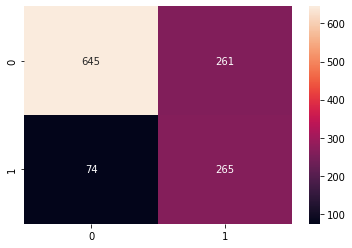

In [255]:
#lr with Lemmatized data and sentiment

X = reviews_data['Lemmatized_str']
Y = reviews_data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.1, random_state =42)

print('x_train :',len(x_train) )
print('x_test :',len(x_test) )
print('y_train :',len(y_train) )
print('y_test :',len(y_test) )

tifd_vec = TfidfVectorizer()
nb_model = MultinomialNB()

# build modeling pipeline 
model = Pipeline([  ('Vectorize', tifd_vec),  ('Classifier',nb_model) ])
model.fit(x_train, y_train)

predictions = model.predict(x_test)
evaluation(predictions, y_test)